<a href="https://colab.research.google.com/github/woojin9605/Practice/blob/main/FCN_result_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%shell
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
unzip PennFudanPed.zip

--2021-02-19 03:32:57--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  31.0MB/s    in 1.7s    

2021-02-19 03:32:59 (31.0 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2021-02-19 03:32:59--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-02-19 03:32:59--
Total wall clock time: 2.0s
Downloaded: 1 files, 51M in 1.7s (31.0 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import models
from torchvision.models.vgg import VGG
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from torch.autograd import Variable

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def get_upsampling_weight(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=np.float64)
    weight[list(range(in_channels)), list(range(out_channels)), :, :] = filt
    return torch.from_numpy(weight).float()

class FCN32s(nn.Module):
  def __init__(self, num_classes, pretrained=True):
    super().__init__()
    vgg16 = models.vgg16(pretrained=True)
    features, classifier = list(vgg16.features.children()), list(vgg16.classifier.children())
    features[0].padding = (100, 100)
    for f in features:
      if 'MaxPool' in f.__class__.__name__:
        f.ceil_mode = True
      elif 'ReLU' in f.__class__.__name__:
        f.inplace = True

    self.features5 = nn.Sequential(*features)

    fc6 = nn.Conv2d(512, 4096, kernel_size=7)
    fc6.weight.data.copy_(classifier[0].weight.data.view(4096, 512, 7, 7))
    fc6.bias.data.copy_(classifier[0].bias.data)

    fc7 = nn.Conv2d(4096, 4096, kernel_size=1)
    fc7.weight.data.copy_(classifier[3].weight.data.view(4096, 4096, 1, 1))
    fc7.bias.data.copy_(classifier[3].bias.data)

    score_fr = nn.Conv2d(4096, num_classes, kernel_size=1)
    score_fr.weight.data.zero_()
    score_fr.bias.data.zero_()

    self.score_fr = nn.Sequential(fc6, nn.ReLU(inplace=True), nn.Dropout(), 
                                  fc7, nn.ReLU(inplace=True), nn.Dropout(), score_fr)
    self.upscore = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, stride=32, bias=False)
    self.upscore.weight.data.copy_(get_upsampling_weight(num_classes, num_classes, 64)) 

  def forward(self, x):
    x_size = x.size()
    pool5 = self.features5(x)
    score_fr = self.score_fr(pool5)
    upscore = self.upscore(score_fr)
    return upscore[:, :, 19: (19 + x_size[2]), 19: (19 + x_size[3])].contiguous()

class FCN16s(nn.Module):
  def __init__(self, num_classes, pretrained=True):
    super().__init__()
    vgg16 = models.vgg16(pretrained=True)
    features, classifier = list(vgg16.features.children()), list(vgg16.classifier.children())
    features[0].padding = (100, 100)
    for f in features:
      if 'MaxPool' in f.__class__.__name__:
        f.ceil_mode = True
      elif 'ReLU' in f.__class__.__name__:
        f.inplace = True

    self.features4 = nn.Sequential(*features[: 24])
    self.features5 = nn.Sequential(*features[24: ])

    self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)


    fc6 = nn.Conv2d(512, 4096, kernel_size=7)
    fc6.weight.data.copy_(classifier[0].weight.data.view(4096, 512, 7, 7))
    fc6.bias.data.copy_(classifier[0].bias.data)

    fc7 = nn.Conv2d(4096, 4096, kernel_size=1)
    fc7.weight.data.copy_(classifier[3].weight.data.view(4096, 4096, 1, 1))
    fc7.bias.data.copy_(classifier[3].bias.data)

    score_fr = nn.Conv2d(4096, num_classes, kernel_size=1)
    score_fr.weight.data.zero_()
    score_fr.bias.data.zero_()

    self.score_fr = nn.Sequential(fc6, nn.ReLU(inplace=True), nn.Dropout(), 
                                  fc7, nn.ReLU(inplace=True), nn.Dropout(), score_fr)
    
    self.upscore_2 =  nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, bias=False)
    self.upscore_16 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=32, stride=16, bias=False)
    self.upscore_2.weight.data.copy_(get_upsampling_weight(num_classes, num_classes, 4))
    self.upscore_16.weight.data.copy_(get_upsampling_weight(num_classes, num_classes, 32))
  
  def forward(self, x):
    x_size = x.size()
    pool4 = self.features4(x)
    pool5 = self.features5(pool4)

    score_fr = self.score_fr(pool5)
    upscore_2 = self.upscore_2(score_fr)

    score_pool4 = self.score_pool4(pool4)
    #print(upscore_2.shape,score_pool4[:, :, 5: (5 + upscore_2.size()[2]), 5: (5 + upscore_2.size()[3])].shape)
    
    score_sum = upscore_2 + score_pool4[:, :, 5: (5 + upscore_2.size()[2]), 5: (5 + upscore_2.size()[3])]

    upscore_16 = self.upscore_16(score_sum)

    return upscore_16[:, :, 27: (27 + x_size[2]), 27: (27 + x_size[3])].contiguous()

class FCN8s(nn.Module):
  def __init__(self, num_classes, pretrained=True):
    super().__init__()
    vgg16 = models.vgg16(pretrained=True)
    features, classifier = list(vgg16.features.children()), list(vgg16.classifier.children())
    features[0].padding = (100, 100)
    for f in features:
      if 'MaxPool' in f.__class__.__name__:
        f.ceil_mode = True
      elif 'ReLU' in f.__class__.__name__:
        f.inplace = True

    self.features3 = nn.Sequential(*features[: 17])
    self.features4 = nn.Sequential(*features[17: 24])
    self.features5 = nn.Sequential(*features[24: ])

    self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1)
    self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)

    fc6 = nn.Conv2d(512, 4096, kernel_size=7)
    fc6.weight.data.copy_(classifier[0].weight.data.view(4096, 512, 7, 7))
    fc6.bias.data.copy_(classifier[0].bias.data)

    fc7 = nn.Conv2d(4096, 4096, kernel_size=1)
    fc7.weight.data.copy_(classifier[3].weight.data.view(4096, 4096, 1, 1))
    fc7.bias.data.copy_(classifier[3].bias.data)

    score_fr = nn.Conv2d(4096, num_classes, kernel_size=1)
    score_fr.weight.data.zero_()
    score_fr.bias.data.zero_()

    self.score_fr = nn.Sequential(fc6, nn.ReLU(inplace=True), nn.Dropout(), 
                                  fc7, nn.ReLU(inplace=True), nn.Dropout(), score_fr)
    
    self.upscore_2_1 =  nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, bias=False)
    self.upscore_2_2 =  nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, bias=False)
    self.upscore_8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, bias=False)

    self.upscore_2_1.weight.data.copy_(get_upsampling_weight(num_classes, num_classes, 4))
    self.upscore_2_2.weight.data.copy_(get_upsampling_weight(num_classes, num_classes, 4))
    self.upscore_8.weight.data.copy_(get_upsampling_weight(num_classes, num_classes, 16))
  
  def forward(self, x):
    x_size = x.size()
    pool3 = self.features3(x)
    pool4 = self.features4(pool3)
    pool5 = self.features5(pool4)

    score_fr = self.score_fr(pool5)
    upscore_2_1 = self.upscore_2_1(score_fr)
    score_pool4 = self.score_pool4(pool4)
    #print(upscore_2.shape,score_pool4[:, :, 5: (5 + upscore_2.size()[2]), 5: (5 + upscore_2.size()[3])].shape)
    score_sum_1 = upscore_2_1 + score_pool4[:, :, 5: (5 + upscore_2_1.size()[2]), 5: (5 + upscore_2_1.size()[3])]

    upscore_2_2 = self.upscore_2_2(score_sum_1)
    score_pool3 = self.score_pool3(pool3)

    #print(upscore_2_2.shape,score_pool3[:, :, 5: (5 + upscore_2_2.size()[2]), 5: (5 + upscore_2_2.size()[3])].shape)

    score_sum_2 = upscore_2_2 + score_pool3[:, :, 9: (9 + upscore_2_2.size()[2]), 9: (9 + upscore_2_2.size()[3])]
    upscore_8 = self.upscore_8(score_sum_2)

    return upscore_8[:, :, 31: (31 + x_size[2]), 31: (31 + x_size[3])].contiguous()

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        mask = np.array(mask)
        masks = np.clip(mask,0,1)

        masks = torch.as_tensor(masks, dtype=torch.float32)
        masks = masks.unsqueeze(0)
        if self.transforms is not None:
            img = self.transforms(img)

        return img, masks
    
    def __len__(self):
        return len(os.listdir('PennFudanPed/PNGImages'))

dataset = PennFudanDataset('PennFudanPed/', transforms=transforms.Compose([transforms.ToTensor()]))
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [3]:
num_classes = 1

fcn_model32 =  FCN32s(num_classes)
fcn_model16 =  FCN16s(num_classes)
fcn_model8 =  FCN8s(num_classes)

img1 = []##########
img_y1 = []
img2 = []
img_y2 = []
img3 = []
img_y3 = []##########

criterion = nn.BCELoss().cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0, 1/170, loss is 0.6931471824645996


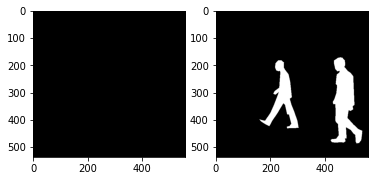

epoch 1, 1/170, loss is 0.12289837747812271


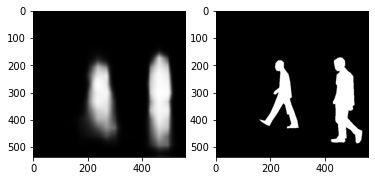

epoch 2, 1/170, loss is 0.09649978578090668


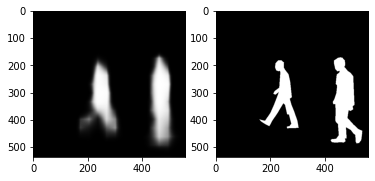

epoch 3, 1/170, loss is 0.08936477452516556


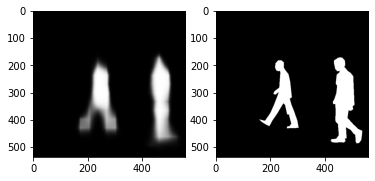

epoch 4, 1/170, loss is 0.07410894334316254


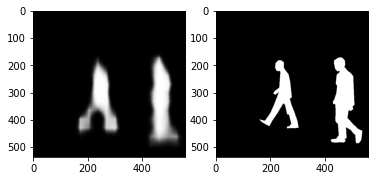

epoch 5, 1/170, loss is 0.07025514543056488


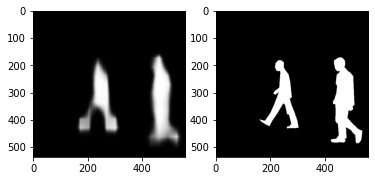

epoch 6, 1/170, loss is 0.0676712617278099


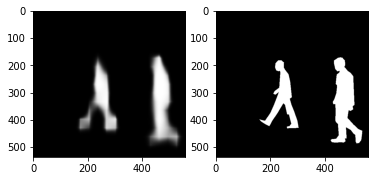

epoch 7, 1/170, loss is 0.0733913853764534


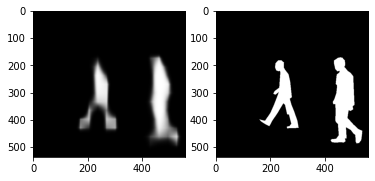

epoch 8, 1/170, loss is 0.07428382337093353


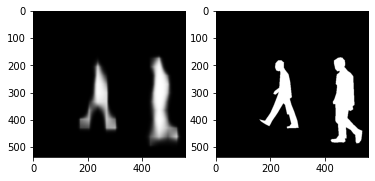

epoch 9, 1/170, loss is 0.0644860491156578


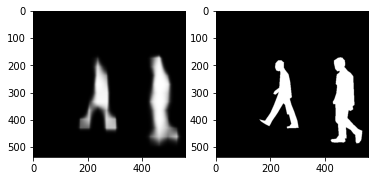

epoch loss = 0.105430


In [4]:
fcn_model = fcn_model32
fcn_model = fcn_model.cuda()
optimizer = optim.SGD(fcn_model.parameters(), lr=1e-2, momentum=0.7) 

for epo in range(10):
  index = 0
  epo_loss = 0
  for img, masks in dataloader:
      #print(item)
      index += 1
      input = img #item['A']
      #print(input.shape)
      y = masks #item['B']
      input = torch.autograd.Variable(input)
      y = torch.autograd.Variable(y)

      input = input.cuda()
      y = y.cuda()

      optimizer.zero_grad()
      output = fcn_model(input)
      output = nn.functional.sigmoid(output)
            #print(output.dtype, y.dtype)
      loss = criterion(output, y)
      loss.backward()
      iter_loss = loss.data
      epo_loss += iter_loss
      optimizer.step()
      output_np = output.cpu().data.numpy().copy().squeeze(1)#.astype('uint8')
      output_np = output_np * 255
            #output_np = np.argmin(output_np, axis=1)
      y_np = y.cpu().data.numpy().copy().squeeze(1)#.astype('uint8')
      y_np = y_np * 255
            #y_np = np.argmin(y_np, axis=1)
            #print(output_np,y_np)
      output_np = torch.as_tensor(output_np, dtype=torch.uint8)
      y_np = torch.as_tensor(y_np, dtype=torch.uint8)
            #print(output_np.shape)
            #print(y_np.shape)
      image1 = Image.fromarray(output_np[0,:, :].byte().numpy())
      image2 = Image.fromarray(y_np[0, :, :].byte().cpu().numpy())

      img1.append(image1) #######
      img_y1.append(image2) ######

      if np.mod(index, 170) == 1:
        print('epoch {}, {}/{}, loss is {}'.format(epo, index, len(dataloader), iter_loss))
        plt.subplot(1, 2, 1) 
        plt.imshow(image1, 'gray')
        plt.subplot(1, 2, 2) 
        plt.imshow(image2, 'gray')
        plt.show()

print('epoch loss = %f'%(epo_loss/len(dataloader)))    

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0, 1/170, loss is 0.6419690251350403


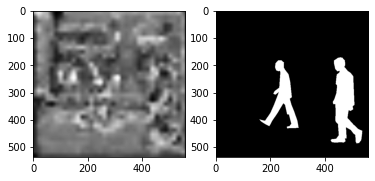

epoch 1, 1/170, loss is 0.04337006062269211


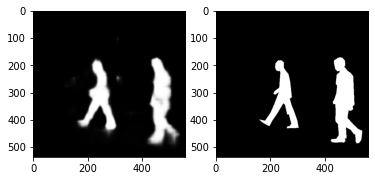

epoch 2, 1/170, loss is 0.03586554527282715


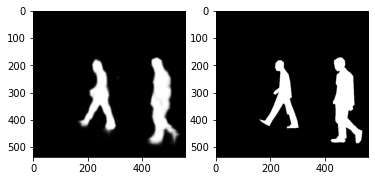

epoch 3, 1/170, loss is 0.03336340934038162


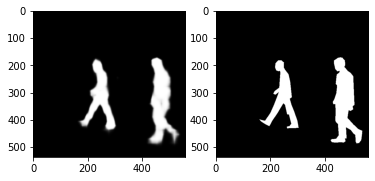

epoch 4, 1/170, loss is 0.03394452482461929


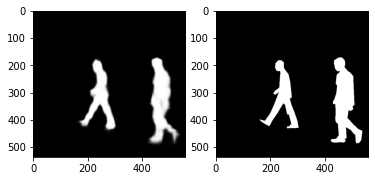

epoch 5, 1/170, loss is 0.033866580575704575


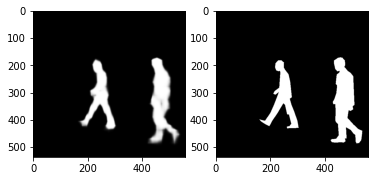

epoch 6, 1/170, loss is 0.03397483378648758


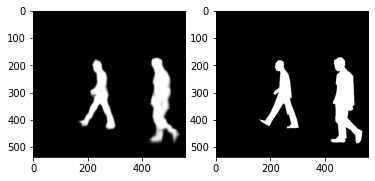

epoch 7, 1/170, loss is 0.03229819983243942


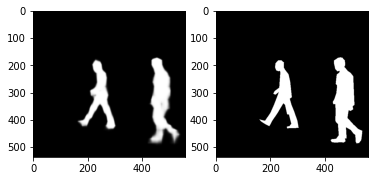

epoch 8, 1/170, loss is 0.030392961576581


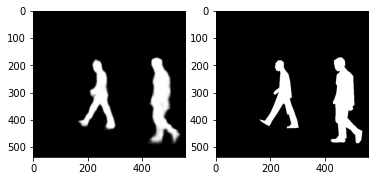

epoch 9, 1/170, loss is 0.028545046225190163


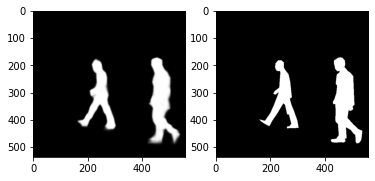

epoch loss = 0.064077


In [5]:
fcn_model = fcn_model16
fcn_model = fcn_model.cuda()
optimizer = optim.SGD(fcn_model.parameters(), lr=1e-2, momentum=0.7) 

for epo in range(10):
  index = 0
  epo_loss = 0
  for img, masks in dataloader:
      #print(item)
      index += 1
      input = img #item['A']
      #print(input.shape)
      y = masks #item['B']
      input = torch.autograd.Variable(input)
      y = torch.autograd.Variable(y)

      input = input.cuda()
      y = y.cuda()

      optimizer.zero_grad()
      output = fcn_model(input)
      output = nn.functional.sigmoid(output)
            #print(output.dtype, y.dtype)
      loss = criterion(output, y)
      loss.backward()
      iter_loss = loss.data
      epo_loss += iter_loss
      optimizer.step()
      output_np = output.cpu().data.numpy().copy().squeeze(1)#.astype('uint8')
      output_np = output_np * 255
            #output_np = np.argmin(output_np, axis=1)
      y_np = y.cpu().data.numpy().copy().squeeze(1)#.astype('uint8')
      y_np = y_np * 255
            #y_np = np.argmin(y_np, axis=1)
            #print(output_np,y_np)
      output_np = torch.as_tensor(output_np, dtype=torch.uint8)
      y_np = torch.as_tensor(y_np, dtype=torch.uint8)
            #print(output_np.shape)
            #print(y_np.shape)
      image1 = Image.fromarray(output_np[0,:, :].byte().numpy())
      image2 = Image.fromarray(y_np[0, :, :].byte().cpu().numpy())

      img2.append(image1) #######
      img_y2.append(image2) ######

      if np.mod(index, 150) == 1:
        print('epoch {}, {}/{}, loss is {}'.format(epo, index, len(dataloader), iter_loss))
        plt.subplot(1, 2, 1) 
        plt.imshow(image1, 'gray')
        plt.subplot(1, 2, 2) 
        plt.imshow(image2, 'gray')
        plt.show()

print('epoch loss = %f'%(epo_loss/len(dataloader)))  

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0, 1/170, loss is 0.8125981092453003


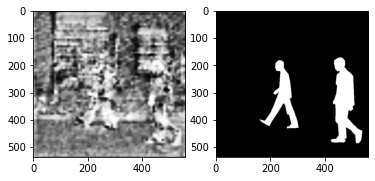

epoch 1, 1/170, loss is 0.057814426720142365


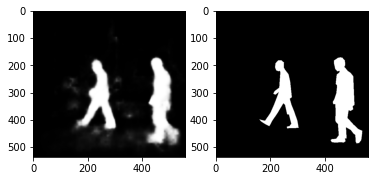

epoch 2, 1/170, loss is 0.03498334437608719


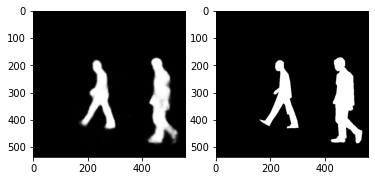

epoch 3, 1/170, loss is 0.031435851007699966


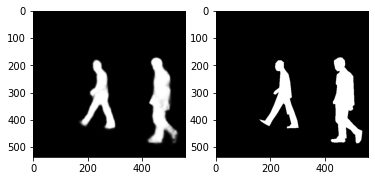

epoch 4, 1/170, loss is 0.028731204569339752


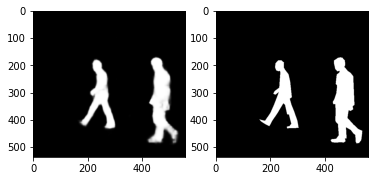

epoch 5, 1/170, loss is 0.02855059504508972


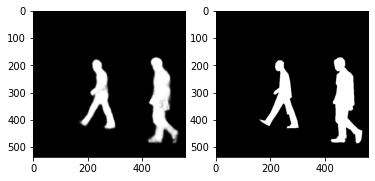

epoch 6, 1/170, loss is 0.029322925955057144


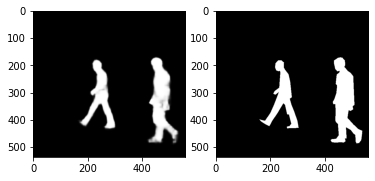

epoch 7, 1/170, loss is 0.027408761903643608


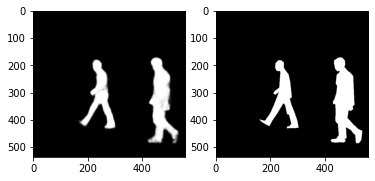

epoch 8, 1/170, loss is 0.02563191018998623


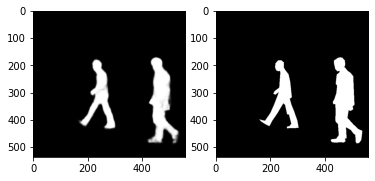

epoch 9, 1/170, loss is 0.02388063073158264


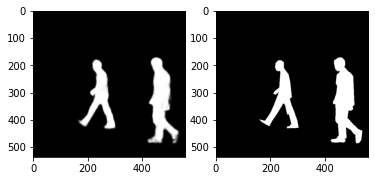

epoch loss = 0.060634


In [6]:
fcn_model = fcn_model8
fcn_model = fcn_model.cuda()
optimizer = optim.SGD(fcn_model.parameters(), lr=1e-2, momentum=0.7) 

for epo in range(10):
  index = 0
  epo_loss = 0
  for img, masks in dataloader:
      #print(item)
      index += 1
      input = img #item['A']
      #print(input.shape)
      y = masks #item['B']
      input = torch.autograd.Variable(input)
      y = torch.autograd.Variable(y)

      input = input.cuda()
      y = y.cuda()

      optimizer.zero_grad()
      output = fcn_model(input)
      output = nn.functional.sigmoid(output)
            #print(output.dtype, y.dtype)
      loss = criterion(output, y)
      loss.backward()
      iter_loss = loss.data
      epo_loss += iter_loss
      optimizer.step()
      output_np = output.cpu().data.numpy().copy().squeeze(1)#.astype('uint8')
      output_np = output_np * 255
            #output_np = np.argmin(output_np, axis=1)
      y_np = y.cpu().data.numpy().copy().squeeze(1)#.astype('uint8')
      y_np = y_np * 255
            #y_np = np.argmin(y_np, axis=1)
            #print(output_np,y_np)
      output_np = torch.as_tensor(output_np, dtype=torch.uint8)
      y_np = torch.as_tensor(y_np, dtype=torch.uint8)
            #print(output_np.shape)
            #print(y_np.shape)
      image1 = Image.fromarray(output_np[0,:, :].byte().numpy())
      image2 = Image.fromarray(y_np[0, :, :].byte().cpu().numpy())

      img3.append(image1) #######
      img_y3.append(image2) ######

      if np.mod(index, 130) == 1:
        print('epoch {}, {}/{}, loss is {}'.format(epo, index, len(dataloader), iter_loss))
        plt.subplot(1, 2, 1) 
        plt.imshow(image1, 'gray')
        plt.subplot(1, 2, 2) 
        plt.imshow(image2, 'gray')
        plt.show()

print('epoch loss = %f'%(epo_loss/len(dataloader)))  

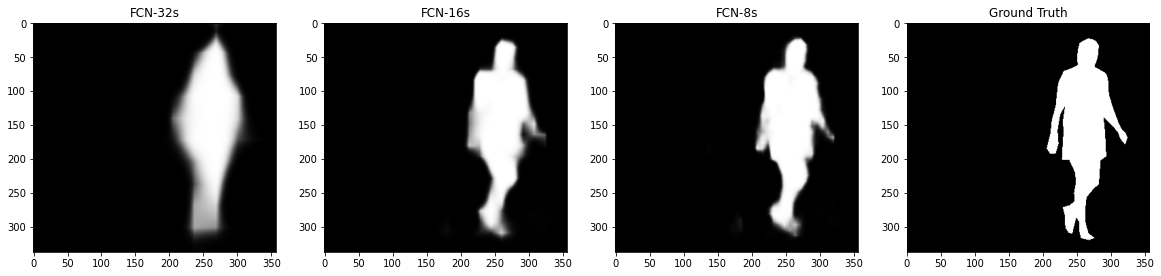

In [20]:
idx = 1682

plt.figure(figsize=(20,10))
plt.subplot(1, 4, 1) 
plt.title('FCN-32s')
plt.imshow(img1[idx], 'gray')
plt.subplot(1, 4, 2) 
plt.title('FCN-16s')
plt.imshow(img2[idx], 'gray')
plt.subplot(1, 4, 3)
plt.title('FCN-8s')
plt.imshow(img3[idx], 'gray')
plt.subplot(1, 4, 4)
plt.title('Ground Truth')
plt.imshow(img_y1[idx], 'gray')
plt.show()

In [14]:
import csv

with open('imgs.csv','w',newline='') as f:
  writer = csv.writer(f)
  writer.writerow(img1)
  writer.writerow(img2)
  writer.writerow(img3)
  writer.writerow(img_y1)